In [1]:
%cd ../cnns/

/home/tony/predicting-poverty/cnns


In [2]:
% matplotlib inline
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.autograd import Variable
from torchvision import transforms
from data import BangladeshDataset, IndiaDataset
from sklearn import metrics
from scipy import stats

In [3]:
sns.set_style("ticks")
sns.set_palette(sns.color_palette("dark", 8))

In [99]:
plt_colors = sns.color_palette()

In [4]:
models_dir = "/home/tony/predicting-poverty/models"

In [57]:
folder_name = "fold_2_l8_cons/7"
sat_type = "Landsat-8"

In [141]:
fold = "fold_1"

Check properties of the data.

In [142]:
dists = np.load("/home/tony/predicting-poverty/data/{}/dists.npy".format(fold))

FileNotFoundError: [Errno 2] No such file or directory: '/home/tony/predicting-poverty/data/fold_1/dists.npy'

In [143]:
np.mean(dists < 2240)

0.070077163829807235

Text(0,0.5,'Density')

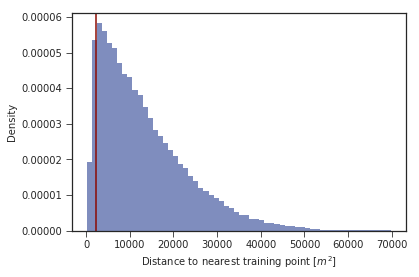

In [119]:
plt.hist(dists[dists < 70000], bins=60, color=plt_colors[0], alpha=0.5, normed=True)
plt.axvline(2240, color=plt_colors[2])
plt.xlabel("Distance to nearest training point [$m^2$]")
plt.ylabel("Density")

In [144]:
train = pd.read_csv("/home/tony/predicting-poverty/data/{}/train.csv".format(fold))
valid = pd.read_csv("/home/tony/predicting-poverty/data/{}/valid.csv".format(fold))
test = pd.read_csv("/home/tony/predicting-poverty/data/{}/test.csv".format(fold))

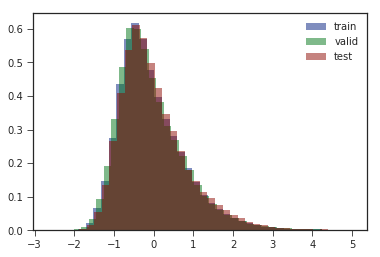

In [147]:
plt.hist(train["secc_cons_per_cap_scaled"][train["secc_cons_per_cap_scaled"] < 5], bins=40, normed=True, alpha=0.5, label="train")
plt.hist(valid["secc_cons_per_cap_scaled"][valid["secc_cons_per_cap_scaled"] < 5], bins=40, normed=True, alpha=0.5, label="valid")
plt.hist(test["secc_cons_per_cap_scaled"][test["secc_cons_per_cap_scaled"] < 5], bins=40, normed=True, alpha=0.5, label="test")
plt.legend()

Loss plots while training.

In [120]:
losses = {
  "train": np.load("{}/{}/losses_train.npy".format(models_dir, folder_name)),
  "val": np.load("{}/{}/losses_val.npy".format(models_dir, folder_name))
}
rsq = {
  "train": np.load("{}/{}/rsq_train.npy".format(models_dir, folder_name)),
  "val": np.load("{}/{}/rsq_val.npy".format(models_dir, folder_name))
}

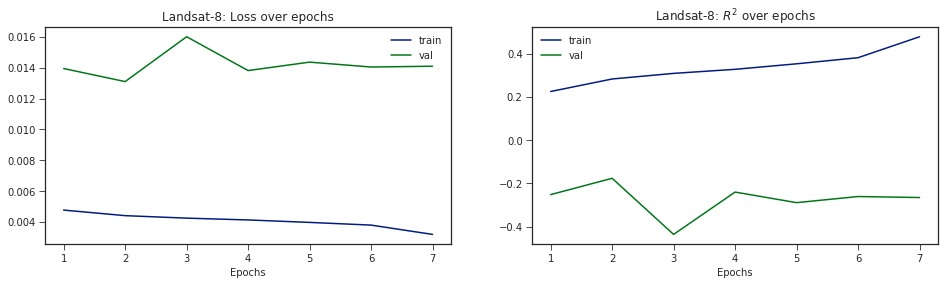

In [121]:
N = len(np.array(losses["train"]))
rsq_cutoff = 0
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, N+1), np.array(losses["train"]), label="train")
plt.plot(np.arange(1, N+1), np.array(losses["val"]), label="val")
plt.title("{}: Loss over epochs".format(sat_type))
plt.xlabel("Epochs")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.arange(rsq_cutoff + 1, len(rsq["train"]) + 1), np.array(rsq["train"])[rsq_cutoff:], label="train")
plt.plot(np.arange(rsq_cutoff + 1, len(rsq["val"]) + 1), np.array(rsq["val"])[rsq_cutoff:], label="val")
plt.title("{}: $R^2$ over epochs".format(sat_type))
plt.xlabel("Epochs")
plt.legend()

In [60]:
np.argmax(rsq["val"]) + 1, np.max(rsq["val"])

(2, -0.17617643631122903)

In [61]:
pctles = np.linspace(1, 100, 30)
r2s = {}

Predicted versus observed plot.

In [62]:
y_pred = np.load("/home/tony/predicting-poverty/models/{}/y_pred.npy".format(folder_name))
y_valid = np.load("/home/tony/predicting-poverty/models/{}/y_true.npy".format(folder_name))

In [63]:
len(y_valid)

81473

Text(0.5,1,'India CNN predicted versus true labels')

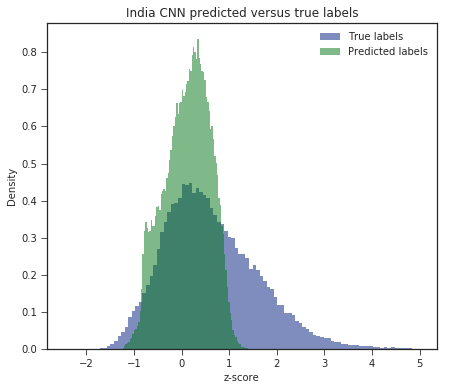

In [70]:
plt.figure(figsize=(7, 6))
plt.hist(y_valid[y_valid < 5], normed=True, bins=100, alpha=0.5, label="True labels");
plt.hist(y_pred[y_pred < 5], normed=True, bins=100,alpha=0.5, label="Predicted labels");
plt.xlabel("z-score")
plt.ylabel("Density")
plt.legend()
plt.title("India CNN predicted versus true labels")

In [66]:
model_r2s = []
for pctle in pctles:
  selector = y_valid <= np.percentile(y_valid, pctle)
  model_r2s.append(stats.pearsonr(y_valid[selector], y_pred[selector])[0] ** 2)

In [23]:
r2s["gbm"] = model_r2s

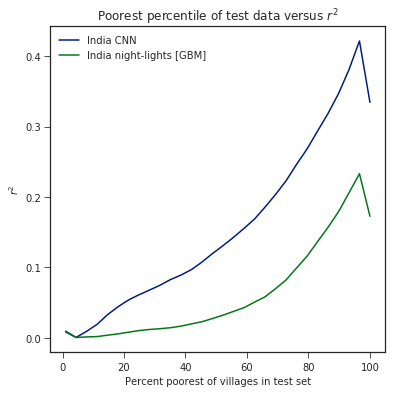

In [16]:
plt.figure(figsize=(6, 6))
plt.plot(pctles, r2s["cnn"], label="India CNN")
plt.plot(pctles, r2s["gbm"], label="India night-lights [GBM]")
plt.title("Poorest percentile of test data versus $r^2$")
plt.xlabel("Percent poorest of villages in test set")
plt.ylabel("$r^2$")
plt.legend();

In [22]:
df = pd.DataFrame(np.array([y_valid, y_pred]).T)

In [23]:
grouped_y_pred = df.groupby(0)[1].mean()

In [24]:
metrics.r2_score(grouped_y_pred.index, grouped_y_pred)

0.10798454245822442

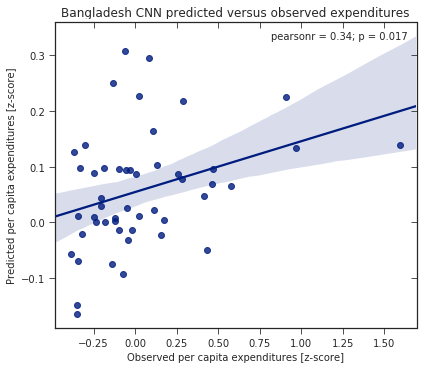

In [25]:
g = sns.JointGrid(grouped_y_pred.index, grouped_y_pred, ratio=100)
g.fig.set_size_inches((6, 5))
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr)
g.ax_joint.set(ylabel="Predicted per capita expenditures [z-score]",
                 xlabel="Observed per capita expenditures [z-score]")
g.ax_joint.set_title("Bangladesh CNN predicted versus observed expenditures");

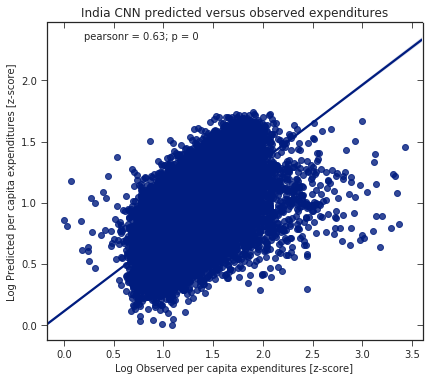

In [15]:
g = sns.JointGrid(np.log(y_valid - np.min(y_valid) + 1), np.log(y_pred - np.min(y_pred) + 1), ratio=100)
g.fig.set_size_inches((6, 5))
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr)
g.ax_joint.set(ylabel="Log Predicted per capita expenditures [z-score]",
                 xlabel="Log Observed per capita expenditures [z-score]")
g.ax_joint.set_title("India CNN predicted versus observed expenditures");

=======

In [73]:
model = None

In [12]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)

In [15]:
model.load_state_dict(torch.load("/home/tony/predicting-poverty/models/{}saved_model.model".format(folder_name)))

In [16]:
model.train(False);

In [17]:
train_csv_path = "../data/valid_east/india_train.csv"
val_csv_path = "../data/valid_east/india_valid.csv"

In [18]:
data_transforms = {
        "train": transforms.Compose([
            transforms.Scale(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Scale(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

In [19]:
home_dir = os.path.expanduser("~")

In [20]:
train_data_dir = "{}/imagery".format(home_dir)

In [23]:
train_dataset = IndiaDataset(csv_file=train_csv_path,
                      root_dir=val_data_dir,
                      transform=data_transforms["val"],
                      sat_type="s1",
                      label="secc_cons_per_cap_scaled")

In [24]:
len(train_dataset)

402085

In [24]:
finalconv_name = 'layer4'

In [25]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

model._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [26]:
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

=============

In [25]:
def predict(img):
  return model(Variable(img.unsqueeze(0))).data[0,0]

In [32]:
truths = []
preds = []

In [ ]:
for i in range(len(train_dataset)):
  truth = train_dataset[i][1]
  pred = predict(train_dataset[i][0])
  truths.append(truth)
  preds.append(pred)

In [ ]:
2

In [ ]:
2

In [34]:
3

3

In [35]:
len(truths)

86125

In [36]:
len(preds)

86125

In [39]:
truths = np.array(truths)
preds = np.array(preds)

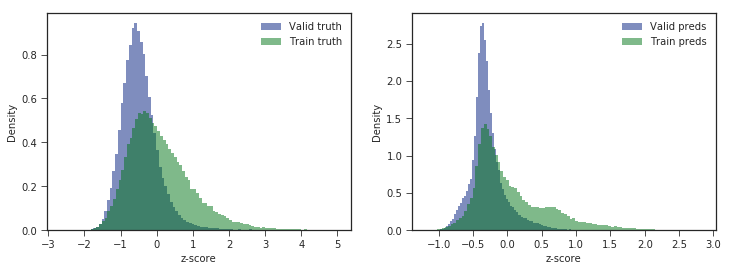

In [64]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(y_valid[y_valid < 5], normed=True, bins=100, alpha=0.5, label="Valid truth");
plt.hist(truths[truths < 5], normed=True, bins=100, alpha=0.5, label="Train truth")
plt.xlabel("z-score")
plt.ylabel("Density")
plt.legend()
plt.subplot(1,2,2)
plt.hist(y_pred[y_pred < 5], normed=True, bins=100,alpha=0.5, label="Valid preds");
plt.hist(preds[preds < 5], normed=True, bins=100, alpha=0.5, label="Train preds")
plt.xlabel("z-score")
plt.ylabel("Density")
plt.legend()
# plt.title("India CNN predicted versus true labels")

In [67]:
np.mean(truths)

0.13720553458287063

In [70]:
np.mean(y_valid)

-0.45036752403431302

In [77]:
preds = [predict(val_dataset[i][0]) for i in range(100)]

NameError: name 'val_dataset' is not defined

In [ ]:
max(preds), np.argmax(preds)

In [ ]:
vis_cam(12);

In [160]:
def vis_cam(idx):
  
  img, label = val_dataset[idx]
  print("Label:\t", label)
  print("Pred:\t", model(Variable(img.unsqueeze(0))).data[0,0])
  feature_conv = features_blobs[-1]
  bz, nc, h, w = feature_conv.shape
  cam = weight_softmax.dot((feature_conv.reshape((nc, h*w))))
  cam = cam.reshape(h, w)
  cam = cam - np.min(cam)
  cam_img = cam / np.max(cam)
  cam_img = cv2.resize(cam_img, (224, 224))
  plt.imshow(cam_img)
  img_orig = ((img.numpy().transpose(1,2,0) * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]))
  plt.imshow(plt.cm.jet(cam_img)[:,:,:3] * 0.2 + img_orig * 0.8)
  return cam

Label:	 162.871589992
Pred:	 198.58660888671875


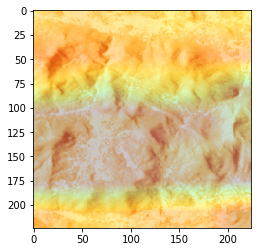

In [214]:
cam = vis_cam(1)

=================

In [117]:
train_csv_path = "../data/bangladesh_2015_train.csv"
val_csv_path = "../data/bangladesh_2015_valid.csv"

In [118]:
val_dataset = BangladeshDataset(csv_file=val_csv_path,
                                root_dir=val_data_dir,
                                transform=data_transforms["val"],
                                sat_type="s1")

In [119]:
y_preds, y_trues = [], []

In [120]:
for i in range(len(val_dataset)):
  img, label = val_dataset[i]
  y_preds.append(predict(img))
  y_trues.append(label)

In [121]:
len(y_preds)

884

In [122]:
len(y_trues)

884

(array([  18.,   94.,  212.,  204.,  164.,  107.,   44.,   26.,    9.,    6.]),
 array([-0.36648071, -0.33872055, -0.3109604 , -0.28320024, -0.25544008,
        -0.22767993, -0.19991977, -0.17215961, -0.14439946, -0.1166393 ,
        -0.08887915]),
 <a list of 10 Patch objects>)

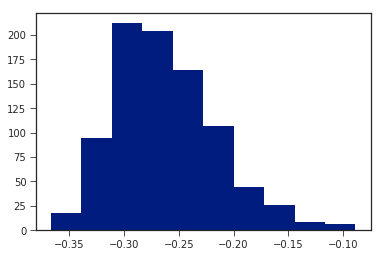

In [125]:
plt.hist(y_preds)

In [126]:
villages = val_dataset.households["Village"]

In [127]:
df = pd.DataFrame(np.array([villages, y_preds, y_trues]).T)

In [128]:
preds = df.groupby(0)[1].mean()

In [129]:
trues = df.groupby(0)[2].mean()

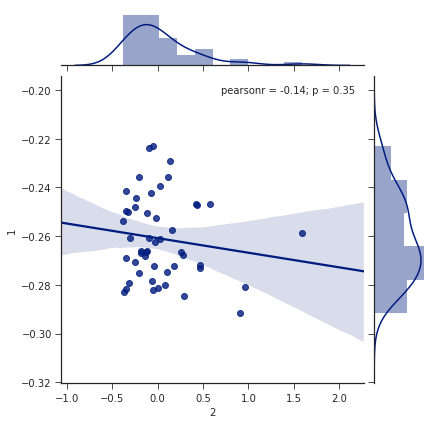

In [130]:
sns.jointplot(trues, preds, kind="reg")

In [131]:
metrics.r2_score(trues, preds)

-0.61979722560865658